# **Capstone project: Diabetes Risk Indications**

**Overview**: In this century, Diabetes is one of the silent killer lifestyle disease impacting millions of population worldwide. A diabetic person's blood sugar regulation system stops being effective resulting in high level of sugar in bloodstream. This high level of blood sugar over the time clinically associated with several life complications like, heart disease, obesity, high blood pressure, kidney failures etc.

Daibetes is incurable but early sign or detection of it can help manage the future risk with certain lifestyle changes like healthy eating, reducing weight, being active and with proper education about the diseaes and regular medical checkups.

Using Machin Learning predictive model, one can get an early indication of the disease and will be able to manage the risk effectively and well in time. As per CDC, many who are at great risk are unaware of it.



# **GOAL**

 To enable early intervention and potential prevention of diabetes, the aim is to develop a machine learning model that accurately identifies individuals at high risk by analyzing their medical history, lifestyle factors, and other relevant data.

 The ML model goal is to predict if an individual is at a risk of diabetes  or not.
# **Data**

In the United States of America, Center for disease control (CDC) annually performs comprehensive health survay called Behavioral Risk Factor Surveillance System (BRFSS). This is a phone survey to collect data on chrnoic health conditions, lifestyle and risk behaviours over a large population acorss all states.

In this project, I am using BRFSS 2023 survey data from CDC : https://www.cdc.gov/brfss/annual_data/annual_2023.html

The data code book at : https://www.cdc.gov/brfss/annual_data/2023/zip/codebook23_llcp-v2-508.zip

The CSV format of BRFSS 2023 Survey data is obtained from : https://www.kaggle.com/datasets/isuruprabath/brfss-2023-csv-dataset

The dataset originally has


*   **Total response ( samples):** 433323

*   **Total Features ( Columns):** 350



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import time


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score,f1_score,roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

!pip install category_encoders
from category_encoders import LeaveOneOutEncoder


from sklearn import set_config
#setting this will display the pipelines
set_config(display="diagram")

warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.4 MB/s eta 0:00:00


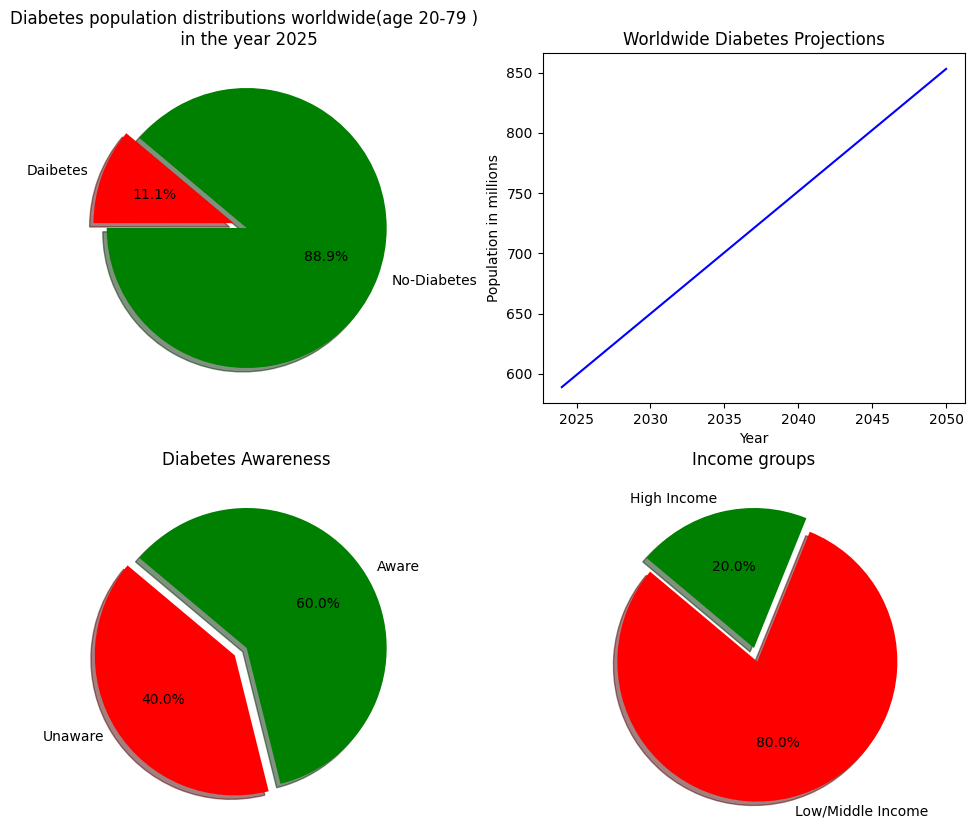

In [2]:
# Daibetes projections
# https://idf.org/about-diabetes/diabetes-facts-figures/


# Worldwide 11.1% population in the age group 20-79 years having diabetes

fig, ax = plt.subplots(2,2, figsize=(12, 10))
labels = ['Daibetes', 'No-Diabetes']
sizes = [11.1, 88.9]
colors = ['red', 'green']
explode = (0.1, 0)
ax[0,0].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
ax[0,0].set_title('Diabetes population distributions worldwide(age 20-79 ) \n in the year 2025')

# In year 2024 589 millions and 853 milliions by 2050
x = [2024,2050]
db = [589,853]
ax[0,1].plot(x,db,color='blue')
ax[0,1].set_xlabel('Year')
ax[0,1].set_ylabel('Population in millions')
ax[0,1].set_title('Worldwide Diabetes Projections')

# Awareness 4 in 10 people are unaware that they have diabetes
labels = ['Unaware', 'Aware']
sizes = [4, 6]
colors = ['red', 'green']
explode = (0.1, 0)
ax[1,0].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
ax[1,0].set_title('Diabetes Awareness')

# Over 4 in 5 adults (81%) with diabetes live in low- and middle-income countries.
labels = ['Low/Middle Income', 'High Income']
sizes = [4, 1]
colors = ['red', 'green']
explode = (0.1, 0)
ax[1,1].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
ax[1,1].set_title('Income groups')
plt.show()


# **Data Understanding**

## Since github limits the size of file upload, the original data has been trimmed to 15%

Use pandas to read in the dataset `BRFSS2023_R.csv` and assign to a meaningful variable name.

In [3]:
# Load dataset into pandas data frame brfss_df
brfss_df = pd.read_csv('data/BRFSS2023_R.csv')
print(brfss_df.shape)

(64998, 350)


# Data descriptions

CDC BRFSS2023 is a generic health survey in the United States consisting of 350 features or responses. Not all responses are relevent to Diabetese related data analysis. Based on my research and knowledge on Diabetes, I have selected 35 out of 350 features.

The descriptiopn of each feature can be obtained from CDC's BRFSS 2023 survey Codebook at : https://www.cdc.gov/brfss/annual_data/2023/zip/codebook23_llcp-v2-508.zip


The selected features and its descriptions are listed here :

1.   diabete4 - (Ever told) (you had) diabetes?  

| Value   | Description|
|---------|-----------|
|    1  | Yes|
|    2 | Yes but female told only during pregnancy|
 |   3 | No|
 |   4 |No, pre-diabetes or borderline diabetes |
 |   7 |Don't know/Not Sure|
 |   9 | Refused|
 |   BLANK | Not asked or Missing|.

2.   diabtype - According to your doctor,what type of diabetes do you have?

| Value | Type|
|-------|------|
|1 |Type 1|
| 2 |Type 2|
| 7 |Don't know/Not Sure|
| 9 |Refused|
| BLANK | Not asked or Missing|

3.   _rfhype6 - Adults who have been told they have high blood pressure by a doctor, nurse, or other health professional

|Value | HighBlood Pressue|
|------|------------------|
|1| No|
| 2 |Yes|
| 9 |Don't know/Not Sure/Refused/Missing|

4.   _rfchol3 - Adults who have had their cholesterol checked and have been told by a doctor, nurse, or other health professional that it was high

|Value| High Cholestrol|
|-----|----------------|
|1 | No|
| 2 |Yes|
| 9 |Don't know/Not Sure Or Refused/Missing|
| BLANK| Missing|


5.   _cholch3 - Cholesterol check within past five years

|Value | Description|
|------|------------|
|1 | Had cholesterol checked in past 5 years|
| 2 | Did not have cholesterol checked in past 5 years|
| 3 |Have never had cholesterol checked|
| 9 |Don't know/Not Sure Or Refused/Missing|

6.   _bmi5 - Body Mass Index (BMI)

| Value| Description|
|------|------------|
| 1-9999| 1 or greater|
|BLANK| Don't know/Refused/Missing|


7.   smoke100 - Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes]

|Value | Description|
|------|------------|
|1| Yes|
| 2 |No|
| 7 |Don't know/Not Sure|
| 9 |Refused|
| BLANK | Not asked or Missing|

8.   cvdstrk3 - (Ever told) (you had) a stroke.

|Value | Description|
|------|------------|
|1| Yes|
| 2 |No|
| 7 |Don't know/Not Sure|
| 9 |Refused|
| BLANK | Not asked or Missing|

9.   _michd - Respondents that have ever reported having coronary heart disease (CHD) or myocardial infarction (MI)

|Value | Description|
|------|------------|
|1| Yes|
| 2 |No|
| BLANK | Not asked or Missing|

10.   exerany2 - During the past month, other than your regular job, did you participate in any physical activities or exercises such as running, calisthenics, golf, gardening, or walking for exercise?

|Value | Description|
|------|------------|
|1| Yes|
| 2 |No|
| 7 |Don't know/Not Sure|
| 9 |Refused|
| BLANK | Not asked or Missing|

11.   primins1 - What is the current source of your primary health insurance?
12.   medcost1 - Was there a time in the past 12 months when you needed to see a doctor but could not because you could not afford it?

|Value | Description|
|------|------------|
|1| Yes|
| 2 |No|
| 7 |Don't know/Not Sure|
| 9 |Refused|
| BLANK | Not asked or Missing|


13.   genhlth - Would you say that in general your health is?

|Value | Description|
|------|------------|
|1| Excellenet|
| 2 |Very Good|
| 3 |Good|
|4| Fair|
|5| Poor|
|7| Don't know/Not Sure|
| 9 |Refused|
| BLANK | Not asked or Missing|

14.   menthlth - Now thinking about your mental health, which includes stress, depression, and problems with emotions, for how many days during the past 30 days was your mental health not good?

|Value | Description|
|------|------------|
| 1-30| No of days|
| 77| Don't know/Not Sure|
|88| None|
| 99 |Refused|
| BLANK | Not asked or Missing|


15.   physhlth - Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good?

|Value | Description|
|------|------------|
| 1-30| No of days|
| 77| Don't know/Not Sure|
|88| None|
| 99 |Refused|
| BLANK | Not asked or Missing|

16.   diffwalk - Do you have serious difficulty walking or climbing stairs?

|Value | Description|
|------|------------|
|1| Yes|
| 2 |No|
| 7 |Don't know/Not Sure|
| 9 |Refused|
| BLANK | Not asked or Missing|

17.   _sex - Calculated sex variable

|Value | Description|
|------|------------|
|1| Male|
|2| Femae|

18.   _ageg5yr - Fourteen-level age category

|Value | Age|
|------|------------|
| 1 |Age 18 to 24|
| 2 |Age 25 to 29|
| 3 |Age 30 to 34|
| 4 |Age 35 to 39|
| 5 |Age 40 to 44|
| 6 |Age 45 to 49|
| 7 |Age 50 to 54|
| 8 |Age 55 to 59|
| 9 |Age 60 to 64|
| 10 |Age 65 to 69|
| 11 |Age 70 to 74|
| 12 |Age 75 to 79|
| 13 |Age 80 or older|
| 14 |Don't know/Refused/Missing|


19.   _educag - Level of education completed

|Value | Age|
|------|------------|
|1 |Did not graduate High School|
| 2 |Graduated High School|
| 3 |Attended College or Technical School|
| 4 |Graduated from College or Technical School|
| 9 |Don't know/Not sure/Missing|

20.   _incomg1 - Income categories

|Value | Income in $$|
|------|------------|  
| 1 | Less than $15,000|
| 2 | $15,000 to < $25,000|
| 3 | $25,000 to < $35,000|
| 4 | $35,000 to < $50,000|
| 5 | $50,000 to < $100,000|
| 6 | $100,000 to < $200,000|
| 7 | $200,000 or more|
| 9 |Don't know/Not sure/Missing|


21. _imprace - Imputed race/ethnicity value  (This value is the reported race/ethnicity or an imputed race/ethnicity, if the respondent refused to give a race/ethnicity. The value of the imputed race/ethnicity will be the most common race/ethnicity response for that region of the state)

|Value | Race|
|------|------------|
|1|	White, Non-Hispanic|
|2 |	Black, Non-Hispanic	|
|3	|Asian, Non-Hispanic	|
|4	|American Indian/Alaskan Native, Non-Hispanic	|
|5	|Hispanic	|
|6	|Other race, Non-Hispanic|


22. _urbstat - Urban/Rural Status

|Value | Label|
|------|------------|
| 1 |Urban counties (_URBNRRL = 1,2,3,4,5) |
| 2 |Rural counties (_URBNRRL = 6) 55,637 |
| BLANK | Not defined or Missing|

23. actin13_ - Estimated Activity Intensity for First Activity

|Value | Label|
|------|------------|
| 0 | Not Moderate or Vigorous or No Activity |
| 1 |Moderate |
| 2 |Vigorous |
| BLANK| Not asked or Missing|


24. _minac12 - Minutes of Physical Activity per week for First Activity

|Value | Label|
|------|------------|
| 0 |Minutes of Activity per week |
| 1 - 99999| Minutes of Activity per week |
| BLANK| Not asked or Missing|



25. _drnkwk2 - Calculated total number of alcoholic beverages consumed per week

|Value | Label|
|------|------------|
| 0 | Did not drink |
| 1 - 98999| Number of drinks per week |
| 99900 |Don't know/Not sure/Refused/Missing |


26. _pacat3 - Physical Activity Categories

|Value | Label|
|------|------------|
| 1 | Highly Active |
|2 |Active |
| 3 |Insufficiently Active |
| 4 |Inactive |
| 9 |Don't know/Not Sure/Refused/Missing|

27. diabedu1 -  When was the last time you took a course or class in how to manage your diabetes yourself?

|Value | Label|
|------|------------|
| 1 | Within the past year (anytime less than 12 months ago)|
|  2 | Within the last 2 years (1 year but less than 2 years ago) |
| 3 |Within the last 3 years (2 years but less than 3 years ago) |
| 4 |Within the last 5 years (3 to 4 years but less than 5 years ago)|
| 5 |Within the last 10 years (5 to 9 years but less than 10 years ago) |
| 6 |10 years ago or more |
| 7 |Don't know/Not sure |
| 8 |Never |
| 9 |Refused |
| BLANK |Not asked or Missing |


28. prediab2 - Has a doctor or other health professional ever told you that you had prediabetes or borderline diabetes? (If Yes - and respondent is female, ask: 'Was this only when you were pregnant?')

|Value | Label|
|------|------------|
| 1 |Yes |
| 2 |Yes, during pregnancy |
| 3 | No |
| 7 |Don't know/Not Sure |
| 9 |Refused |
| BLANK |Not asked or Missing |

29. pdiabts1 - When was the last time you had a blood test for high blood sugar or diabetes by a doctor, nurse, or other health professional?

|Value | Label|
|------|------------|
| 1 |Within the past year (anytime less than 12 months ago)|
| 2 |Within the past 2 years (1 year but less than 2 years)|
| 3 |Within the past 3 years (2 years but less than 3 years)|
| 4 |Within the past 5 years (3 to 4 years but less than 5 years ago) |
| 5 |Within the past 10 years (5 to 9 years but less than 10 years ago) |
| 6 | 10 or more years ago |
| 7 |Don't know / Not sure |
| 8 |Never |
| 9 |Refused |
| BLANK | Not asked or Missing |

30. pregnant - To your knowledge, are you now pregnant?

|Value | Label|
|------|------------|
| 1 |Yes |
| 2 |No |
| 7 |Don't know/Not Sure |
|9 |Refused |
| BLANK |Not asked or Missing |

31. toldhi3 -  Have you ever been told by a doctor, nurse or other health professional that your cholesterol is high?

|Value | Label|
|------|------------|
| 1 | Yes |
| 2 | No |
| 7 | Don't know/Not Sure|
|9 | Refused |
| BLANK |Not asked or Missing |

32. bphigh6 - Have you ever been told by a doctor, nurse or other health professional that you have high blood pressure? (If Yes - and respondent is female, ask Was this only when you were pregnant?.)

|Value | Label|
|------|------------|
| 1 |Yes |
| 2 |Yes, but female told only during pregnancy|
| 3 |No |
| 4 |Told borderline high or pre-hypertensive or elevated blood pressure |
|7 |Don't know/Not Sure |
| 9| Refused |
| BLANK |Not asked or Missing |

33. strength - During the past month, how many times per week or per month did you do physical activities or exercises to STRENGTHEN your muscles?

|Value | Label|
|------|------------|
| 101 - 199 |Times per week |
| 201 - 299 |Times per month |
| 777 |Don't know / Not sure |
| 888 | Never |
| 999 |Refused |
| BLANK |Not asked or Missing |

34. exract12 -  What type of physical activity or exercise did you spend the most time doing during the past month?

|Value | Label|
|------|------------|
| 1 | Walking |
| 2 | Running or jogging |
| 3 |Gardening or yard work |
| 4 |Bicycling or bicycling machine exercise |
| 5 |Aerobics video or class |
| 6 |Calisthenics |
| 7 |Elliptical/EFX machine exercise |
| 8 |Household activities |
| 9 |Weight lifting |
| 10 |Yoga, Pilates, or Tai Chi |
| 11 |Other |
| 77 |Don't know/Not Sure |
|99 |Refused |
| BLANK |Not asked or Missing |


















In [4]:
# Trim the original dataset into diabetes specific dataset

diabetes_df = brfss_df[[ '_imprace', '_urbstat', 'actin13_', '_minac12',
                        '_drnkwk2', '_pacat3', 'diabedu1',  'prediab2', 'pdiabts1',
                         'pregnant', 'toldhi3', 'bphigh6',  'strength', 'exract12',
                         'diabete4', 'diabtype','_rfhype6', '_rfchol3', '_cholch3',
                         '_bmi5',    'smoke100',  'cvdstrk3', '_michd' , 'exerany2',
                         'primins1', 'medcost1', 'genhlth', 'menthlth', 'physhlth',
                         'diffwalk', '_sex',  '_ageg5yr',    '_educag', '_incomg1' ]]




diabetes_df.shape



(64998, 34)

### Understanding the Features


Data examination to determine if any of the features are missing values or need to be coerced to a different data type.


In [5]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64998 entries, 0 to 64997
Data columns (total 34 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   _imprace  64998 non-null  int64  
 1   _urbstat  63734 non-null  float64
 2   actin13_  47598 non-null  float64
 3   _minac12  46641 non-null  float64
 4   _drnkwk2  64998 non-null  int64  
 5   _pacat3   64998 non-null  int64  
 6   diabedu1  3633 non-null   float64
 7   prediab2  24918 non-null  float64
 8   pdiabts1  24931 non-null  float64
 9   pregnant  11492 non-null  float64
 10  toldhi3   57219 non-null  float64
 11  bphigh6   64996 non-null  float64
 12  strength  64996 non-null  float64
 13  exract12  48823 non-null  float64
 14  diabete4  64995 non-null  float64
 15  diabtype  3638 non-null   float64
 16  _rfhype6  64998 non-null  int64  
 17  _rfchol3  57219 non-null  float64
 18  _cholch3  64998 non-null  int64  
 19  _bmi5     58916 non-null  float64
 20  smoke100  62030 non-null  fl

In [6]:
diabetes_df.head()

,_imprace,_urbstat,actin13_,_minac12,_drnkwk2,_pacat3,diabedu1,prediab2,pdiabts1,pregnant,...,primins1,medcost1,genhlth,menthlth,physhlth,diffwalk,_sex,_ageg5yr,_educag,_incomg1
0,1,2.0,1.0,840.0,0,1,NaN,NaN,NaN,2.0,...,77.0,2.0,4.0,30.0,88.0,1.0,2,6,3,9
1,1,1.0,NaN,NaN,0,4,NaN,NaN,NaN,NaN,...,3.0,2.0,2.0,88.0,88.0,2.0,2,10,2,5
2,1,1.0,1.0,120.0,23,9,NaN,NaN,NaN,NaN,...,1.0,2.0,2.0,3.0,88.0,2.0,2,9,4,6
3,5,1.0,2.0,270.0,0,1,NaN,NaN,NaN,NaN,...,3.0,2.0,3.0,88.0,88.0,2.0,1,12,3,9
4,1,1.0,1.0,60.0,700,3,NaN,NaN,NaN,NaN,...,1.0,2.0,2.0,88.0,88.0,2.0,1,6,3,5


In [7]:
# Find percentage of null in each column of dataset
diabetes_df.isnull().mean()*100

,0
_imprace,0.000000
_urbstat,1.944675
actin13_,26.770054
_minac12,28.242407
_drnkwk2,0.000000
_pacat3,0.000000
diabedu1,94.410597
prediab2,61.663436
pdiabts1,61.643435
pregnant,82.319456


## Based on % of missing number of data and its significance, We can remove these features to keep the learning un-biased.

1.   diabedu1 - 94.406020 % missing
2.   prediab2 - 61.656316 % missing
3.   pdiabts1 - 61.633931 % missing
4.   pregnant - 82.413119 % missing
5.   diabtype - 94.397943 % missing








In [8]:
# Drop diabedu1 , prediab2, pdiabts1 ,pregnant,diabtype from dataset
diabetes_df_reduced = diabetes_df.drop(['diabedu1', 'prediab2', 'pdiabts1', 'pregnant', 'diabtype', 'actin13_','exract12'], axis=1)
diabetes_df_reduced.shape

(64998, 27)

### Re-naming the columns to enhance readability

In [9]:
# renaming columns to increase readability
diabetes_df_reduced.rename(columns={
    '_imprace': 'race',
    '_urbstat': 'urban_status',
    '_minac12': 'minutes_pa_per_wk',
    '_drnkwk2': 'alcoh_per_wk',
    '_pacat3': 'pa_level',
    '_rfhype6': 'hbp',
    '_rfchol3': 'hchol',
    '_cholch3': 'chol_chk',
    '_bmi5': 'bmi',
    'smoke100': 'smoke100',
    'cvdstrk3': 'stroke',
    '_michd': 'Heart_disease',
    'exerany2': 'exercise',
    'primins1': 'insurance',
    'medcost1': 'medcost_afford',
    'genhlth': 'genhlth',
    'menthlth': 'menthlth',
    'physhlth': 'physhlth',
    'diffwalk': 'diffwalk',
    '_sex': 'sex',
    '_ageg5yr': 'age',
    '_educag': 'education',
    '_incomg1': 'income',
    'strength': 'strength_exercise',
    'diabete4': 'diabetes',
    'toldhi3': 'told_high_chol',
    'bphigh6': 'told_high_bp'
}, inplace=True)

#print column names
print(diabetes_df_reduced.columns)
print(diabetes_df_reduced.shape)



Index(['race', 'urban_status', 'minutes_pa_per_wk', 'alcoh_per_wk', 'pa_level',
       'told_high_chol', 'told_high_bp', 'strength_exercise', 'diabetes',
       'hbp', 'hchol', 'chol_chk', 'bmi', 'smoke100', 'stroke',
       'Heart_disease', 'exercise', 'insurance', 'medcost_afford', 'genhlth',
       'menthlth', 'physhlth', 'diffwalk', 'sex', 'age', 'education',
       'income'],
      dtype='object')
(64998, 27)


### Preprocess Cholestrol data
toldhi3 - Have you ever been told by a doctor, nurse or other health professional that your cholesterol is high?
Value	Label
1	Yes
2	No
7	Don't know/Not Sure
9	Refused
BLANK	Not asked or Missing

_rfchol3 - Adults who have had their cholesterol checked and have been told by a doctor, nurse, or other health professional that it was high
Value	High Cholestrol
1	No
2	Yes
9	Don't know/Not Sure Or Refused/Missing
BLANK	Missing




In [10]:
#print unique values of hchol column
print(diabetes_df_reduced['hchol'].unique())
print(diabetes_df_reduced['told_high_chol'].unique())


[ 1.  2. nan  9.]
[ 2.  1. nan  7.  9.]


In [11]:
# plot hchol vs told_high_chol


# Encode told_hi_chol with value 2:0 and replace hchol 1:0,2: 1
diabetes_df_reduced['told_high_chol'] = diabetes_df_reduced['told_high_chol'].replace(2, 0)
diabetes_df_reduced['hchol'] = diabetes_df_reduced['hchol'].replace({1:0,2:1})

#print unique values of told_high_chol and hchol column
print(diabetes_df_reduced['told_high_chol'].unique())
print(diabetes_df_reduced['hchol'].unique())



[ 0.  1. nan  7.  9.]
[ 0.  1. nan  9.]


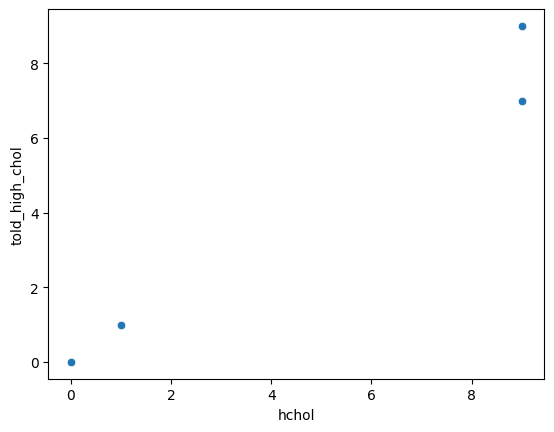

11.968060555709407
11.968060555709407


In [12]:
sns.scatterplot(data=diabetes_df_reduced, x='hchol', y='told_high_chol')
plt.show()

#print % of null for hchol and told_high_chol
print(diabetes_df_reduced['hchol'].isnull().mean()*100)
print(diabetes_df_reduced['told_high_chol'].isnull().mean()*100)

### Both told_high_chol and hchol are highly correlated . We can eliminate told_high_chol coloumn and keep just hchol feature

In [13]:
# drop coloumn told_high_chol
diabetes_df_reduced = diabetes_df_reduced.drop('told_high_chol', axis=1)

#drop nan and value 9 from hchol coloumn
diabetes_df_reduced = diabetes_df_reduced.dropna(subset=['hchol'])
diabetes_df_reduced = diabetes_df_reduced[diabetes_df_reduced['hchol'] != 9]
#print unique values of hchol
print(diabetes_df_reduced['hchol'].unique())

[0. 1.]


### Preprocess hbp and told_high_bp column

_rfhype6/hbp - Adults who have been told they have high blood pressure by a doctor, nurse, or other health professional
Value	HighBlood Pressue
1	No
2	Yes
9	Don't know/Not Sure/Refused/Missing


bphigh6 - Have you ever been told by a doctor, nurse or other health professional that you have high blood pressure? (If Yes - and respondent is female, ask Was this only when you were pregnant?.)
Value	Label
1	Yes
2	Yes, but female told only during pregnancy
3	No
4	Told borderline high or pre-hypertensive or elevated blood pressure
7	Don't know/Not Sure
9	Refused
BLANK	Not asked or Missing



In [14]:
#print unique values of hchol column
print(diabetes_df_reduced['hbp'].unique())
print(diabetes_df_reduced['told_high_bp'].unique())

# Encode told_hi_bp (2,3 NO) and (1,4 , yes) with value 2,3:0 and 1:4:1
diabetes_df_reduced['told_high_bp'] = diabetes_df_reduced['told_high_bp'].replace([2,3], 0)
diabetes_df_reduced['told_high_bp'] = diabetes_df_reduced['told_high_bp'].replace([1,4], 1)
diabetes_df_reduced['hbp'] = diabetes_df_reduced['hbp'].replace({1:0,2:1})

#print unique values of told_high_chol and hchol column
print(diabetes_df_reduced['told_high_bp'].unique())
print(diabetes_df_reduced['hbp'].unique())

[1 2 9]
[3. 1. 4. 2. 7. 9.]
[0. 1. 7. 9.]
[0 1 9]


Drop told_high_bp and keep hbp and drop with value 9

In [15]:
# drop told_high_bp and value with 9
diabetes_df_reduced = diabetes_df_reduced.drop('told_high_bp', axis=1)
diabetes_df_reduced = diabetes_df_reduced[diabetes_df_reduced['hbp'] != 9]
#print unique values of hchol
print(diabetes_df_reduced['hbp'].unique())

[0 1]


(56586, 25)


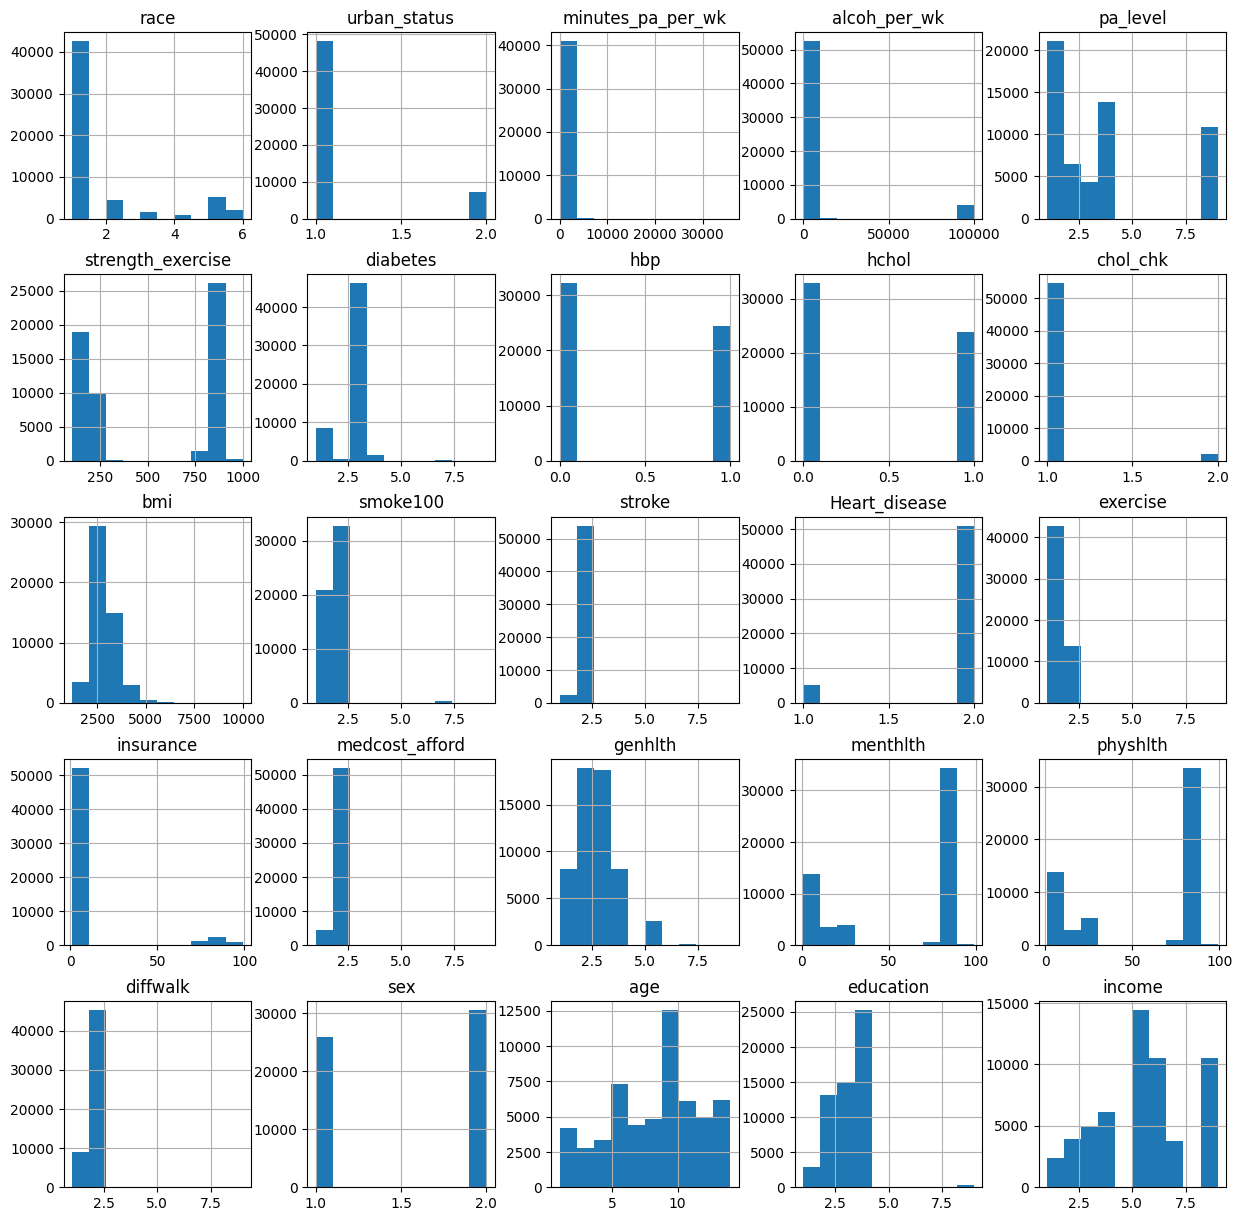

In [16]:
# print shape of dataframe
print(diabetes_df_reduced.shape)
diabetes_df_reduced.hist(figsize=(15,15))
plt.show()

## Based on feature histogram, follwing are the stratgies to replace missing value (Nan)

Numerical categories:

1.   bmi --> Mean
2.   minutes_pa_per_wk --> Mean

Rest are categorical features and LOO can be used to replace missing values.





In [17]:
# Replace Nan of _bmi5, padur1 and _minac12 with mean and median

imputer_mean = SimpleImputer(strategy='mean')
imputer_median = SimpleImputer(strategy='median')

diabetes_df_reduced['bmi'] = imputer_mean.fit_transform(diabetes_df_reduced[['bmi']])
diabetes_df_reduced['minutes_pa_per_wk'] = imputer_mean.fit_transform(diabetes_df_reduced[['minutes_pa_per_wk']])

In [18]:
# Find percentage of null in each column of dataset
diabetes_df_reduced.isnull().mean()*100

,0
race,0.000000
urban_status,2.044675
minutes_pa_per_wk,0.000000
alcoh_per_wk,0.000000
pa_level,0.000000
strength_exercise,0.000000
diabetes,0.001767
hbp,0.000000
hchol,0.000000
chol_chk,0.000000


In [19]:
# print unique values of diabete4 column
diabetes_df_reduced['diabetes'].unique()

array([ 3.,  1.,  2.,  4.,  7., nan,  9.])

### Feature Engineering

The goal is to predict a diabetic risk individuals.

The target values are

|Value	|Description|
|-------|-----------|
|1	|Yes|
|2	|Yes but female told only during pregnancy|
|3	|No|
|4	|No, pre-diabetes or borderline diabetes|
|7	|Don't know/Not Sure|
|9	|Refused|
|BLANK	|Not asked or Missing|

7, 9 , Nan ==> Drop it
2,3 encode as 0 to indicate NO diabetes risk
1,4 encode as 1 to indicate risk


Prepare the features and target column for modeling with appropriate encoding and transformations.

In [20]:
# drop value 7, 9 and nan from daibetes column
diabetes_df_reduced = diabetes_df_reduced[diabetes_df_reduced['diabetes'] != 7]
diabetes_df_reduced = diabetes_df_reduced[diabetes_df_reduced['diabetes'] != 9]
diabetes_df_reduced = diabetes_df_reduced.dropna(subset=['diabetes'])

# Encode diabetes with value replace 2,3:0 and 1,4: 1
diabetes_df_reduced['diabetes'] = diabetes_df_reduced['diabetes'].replace([2,3], 0)
diabetes_df_reduced['diabetes'] = diabetes_df_reduced['diabetes'].replace([1,4], 1)

#print unique values of diabetes column
print(diabetes_df_reduced['diabetes'].unique())

#print shape
print(diabetes_df_reduced.shape)



[0. 1.]
(56496, 25)


In [21]:
# drop mising values
diabetes_df_reduced = diabetes_df_reduced.dropna()
diabetes_df_reduced.shape

(52427, 25)

In [22]:
# Check for number of nulls
diabetes_df_reduced.isnull().sum()

,0
race,0
urban_status,0
minutes_pa_per_wk,0
alcoh_per_wk,0
pa_level,0
strength_exercise,0
diabetes,0
hbp,0
hchol,0
chol_chk,0


### Local enviornment execution limitations
Training a simple model with 350K+ number of samples hits system limitations. So for the purpose of this assignement, randomly picking only 10k samples for model training.

In [23]:
# randomly select 10K samples for local execution purposes
import random
random.seed(42)
diabetes_df_n = diabetes_df_reduced.sample(n=10000, random_state=42)
diabetes_df_n.shape

(10000, 25)

Percentage of Yes: 0.1731
Percentage of No: 0.8269


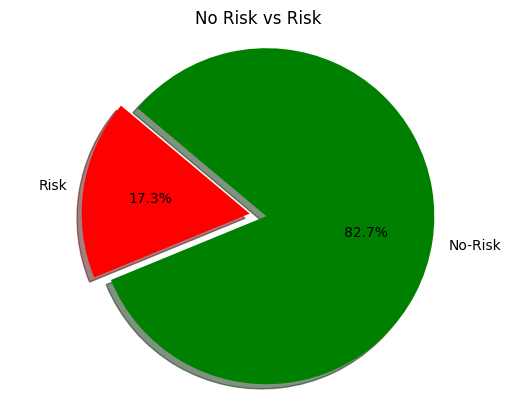

In [24]:
# Determine if its balanced or imbalanced dataset
# Find the percentage of diabete4 as 0 vs 1

yes_count = (diabetes_df_n['diabetes'] == 1).sum()
no_count = (diabetes_df_n['diabetes'] == 0).sum()
per_yes = yes_count / (yes_count + no_count)
per_no = no_count / (yes_count + no_count)
print(f"Percentage of Yes: {per_yes}")
print(f"Percentage of No: {per_no}")

# pie plot
labels = ['Risk', 'No-Risk']
sizes = [per_yes, per_no]
colors = ['red', 'green']
explode = (0.1, 0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('No Risk vs Risk')
plt.show()

**Imbalanced class**
The data is highly imbalanced. only 17.5% has 'Risk' where as 82.5% has No-Risk for diabetes.


1.   Need to use stratify in train and test splitting of data
2.   Need to SMOTE the training data i.e synthetically oversample the minority class



### Train/Test Split


In [25]:
# Define features (X) and target (y)
X = diabetes_df_n.drop('diabetes', axis=1)
y = diabetes_df_n['diabetes']

#Split train and test data with stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)



In [26]:
# normalize the column values and smote the training data set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE the  training data
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

#Size of resampled data
X_train_resampled.shape, X_test_scaled.shape


((11576, 24), (3000, 24))

### A Baseline Model : Logistic Regression model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?


In [27]:
# Create simple Logistic regression model

results = {
    "Model" : [],
    "Train Time" : [],
    "Train Accuracy" : [],
    "Test Accuracy" : [],
    "Recall" : [],
    "F1-Score" : [],
    "AUC" : []

}

start_time = time.time()
lr = LogisticRegression().fit(X_train_resampled, y_train_resampled)
fit_time = (time.time() - start_time)

#Evaluate train and test score
train_score = lr.score(X_train_resampled, y_train_resampled)
test_score = lr.score(X_test_scaled, y_test)
recallscore = recall_score(y_test, lr.predict(X_test_scaled))
f1score = f1_score(y_test, lr.predict(X_test_scaled))
aucscore = roc_auc_score(y_test, lr.predict(X_test_scaled))

# Append the results
results["Model"].append("Logistic Regression")
results["Train Time"].append(fit_time)
results["Train Accuracy"].append(train_score)
results["Test Accuracy"].append(test_score)
results["Recall"].append(recallscore)
results["F1-Score"].append(f1score)
results["AUC"].append(aucscore)

#print results
results_df = pd.DataFrame(results)
results_df

,Model,Train Time,Train Accuracy,Test Accuracy,Recall,F1-Score,AUC
0,Logistic Regression,0.027706,0.732291,0.702333,0.703276,0.449784,0.702706


### Score the Model

What is the accuracy of your model?



In [28]:
# Print accuracy of the model
print(f"Train Accuracy: {train_score}")
print(f"Test Accuracy: {test_score}")

Train Accuracy: 0.7322909467864548
Test Accuracy: 0.7023333333333334


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, comparing the fit time of each of the models.  Presented the findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [29]:
models = {
    'knn': KNeighborsClassifier(),
    'svc': SVC(),
    'decisiontreeclassifier': DecisionTreeClassifier()
}

# Fit the data fo each model
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train_resampled, y_train_resampled)
    fit_time = (time.time() - start_time)

    # Train and test scores
    train_score = model.score(X_train_resampled, y_train_resampled)
    test_score = model.score(X_test_scaled, y_test)
    recallscore = recall_score(y_test, model.predict(X_test_scaled))
    f1score = f1_score(y_test, model.predict(X_test_scaled))
    aucscore = roc_auc_score(y_test, model.predict(X_test_scaled))

    results["Model"].append(name)
    results["Train Time"].append(fit_time)
    results["Train Accuracy"].append(train_score)
    results["Test Accuracy"].append(test_score)
    results["Recall"].append(recallscore)
    results["F1-Score"].append(f1score)
    results["AUC"].append(aucscore)

# print the results
results_df = pd.DataFrame(results)
results_df



,Model,Train Time,Train Accuracy,Test Accuracy,Recall,F1-Score,AUC
0,Logistic Regression,0.027706,0.732291,0.702333,0.703276,0.449784,0.702706
1,knn,0.002801,0.882516,0.676667,0.618497,0.398263,0.653666
2,svc,7.028745,0.860228,0.741667,0.539499,0.419476,0.661729
3,decisiontreeclassifier,0.113857,1.000000,0.743000,0.364162,0.328982,0.593205


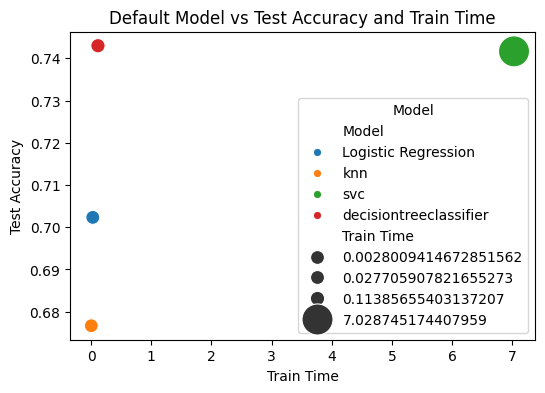

In [30]:
# Scatter Plot Model vs Test acuracy and Train time as bubble size

plt.figure(figsize=(6, 4))
sns.scatterplot(data=results_df, x='Train Time', y='Test Accuracy', hue='Model', size='Train Time', sizes=(100, 500))
plt.title('Default Model vs Test Accuracy and Train Time')
plt.xlabel('Train Time')
plt.ylabel('Test Accuracy')
plt.legend(title='Model')
plt.show()

### Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

# Hyperparameter tuning and grid serach


*   KNN neighbors : 3,5,7
*   Logitstic regression : [0.1 , 1, 10]
*   SVC Kernel : Linear and Gaussian
*   Decision Tree depth : 5,10,15





In [31]:
# Hyperparameter tuning using grid search

models_tunned = {
    'knn': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}),
    'logisticregression': (LogisticRegression(max_iter=1000), {'C': [0.1, 1, 10]}),
    'svc': (SVC(), {'C': [0.1, 1, 10], 'kernel': ['rbf']}),
    'decisiontreeclassifier': (DecisionTreeClassifier(), {'max_depth': [5, 10, 15]})
}

In [32]:
results_tunned = {
    "Model" : [],
    "Train Time" : [],
    "Train Accuracy" : [],
    "Test Accuracy" : [],
    "Recall" : [],
    "F1-Score" : [],
    "AUC" : [],
    "Best Parameters" : []

}

for name, (model, params) in models_tunned.items():

    # Perform grid search
    grid_search = GridSearchCV(estimator = model, param_grid=params,scoring ='accuracy', cv=5, n_jobs=-1)

    # Fit the model and time it
    start_time = time.time()
    grid_search.fit(X_train_resampled, y_train_resampled)
    fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])

    # Get the best estimator
    best_model = grid_search.best_estimator_

    #Get the best parameter
    best_params = grid_search.best_params_

    # Evaluate on training and test sets
    train_score = best_model.score(X_train_resampled, y_train_resampled)
    test_score = best_model.score(X_test_scaled, y_test)
    recallscore = recall_score(y_test, best_model.predict(X_test_scaled))
    f1score = f1_score(y_test, best_model.predict(X_test_scaled))
    aucscore = roc_auc_score(y_test, best_model.predict(X_test_scaled))

    # Append the results
    results_tunned["Model"].append(name)
    results_tunned["Train Time"].append(fit_time)
    results_tunned["Train Accuracy"].append(train_score)
    results_tunned["Test Accuracy"].append(test_score)
    results_tunned["Best Parameters"].append(best_params)
    results_tunned["Recall"].append(recallscore)
    results_tunned["F1-Score"].append(f1score)
    results_tunned["AUC"].append(aucscore)

    print("The best parameters are ", best_params)

#print the results_tunned
results_tunned_df = pd.DataFrame(results_tunned)
results_tunned_df

The best parameters are  {'n_neighbors': 3}
The best parameters are  {'C': 0.1}
The best parameters are  {'C': 10, 'kernel': 'rbf'}
The best parameters are  {'max_depth': 15}


,Model,Train Time,Train Accuracy,Test Accuracy,Recall,F1-Score,AUC,Best Parameters
0,knn,1.752440,0.920525,0.692333,0.547206,0.380952,0.634949,{'n_neighbors': 3}
1,logisticregression,0.102905,0.732205,0.702000,0.703276,0.449507,0.702504,{'C': 0.1}
2,svc,27.241989,0.942899,0.762333,0.396917,0.366222,0.617846,"{'C': 10, 'kernel': 'rbf'}"
3,decisiontreeclassifier,0.377651,0.967001,0.754667,0.358382,0.335740,0.597974,{'max_depth': 15}


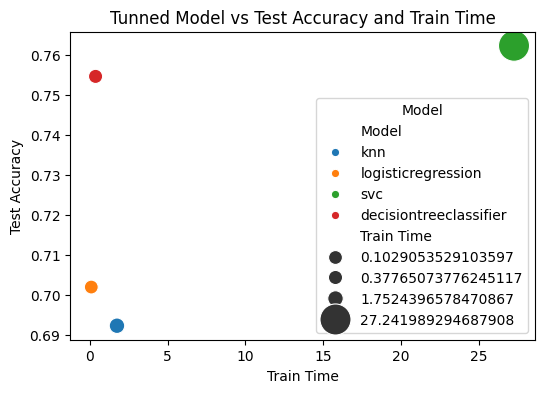

In [33]:
# Scatter Plot Model vs Test acuracy and Train time as bubble size

plt.figure(figsize=(6, 4))
sns.scatterplot(data=results_tunned_df, x='Train Time', y='Test Accuracy', hue='Model', size='Train Time', sizes=(100, 500))
plt.title('Tunned Model vs Test Accuracy and Train Time')
plt.xlabel('Train Time')
plt.ylabel('Test Accuracy')
plt.legend(title='Model')
plt.show()


# Model comparision based on Confusion Matrix

* The purpose of confusion matrix is to provide the absolute count of false classifications ie. False Positive and False Negative

In [34]:
# Predictions from each tunned models
lgr_mod = LogisticRegression(C= 0.1).fit(X_train_resampled, y_train_resampled)
lgr_preds = lgr_mod.predict(X_test_scaled)

svc_mod = SVC(C= 10, kernel='rbf').fit(X_train_resampled, y_train_resampled)
svc_preds = svc_mod.predict(X_test_scaled)

tree_mod = DecisionTreeClassifier(max_depth= 15).fit(X_train_resampled, y_train_resampled)
tree_preds = tree_mod.predict(X_test_scaled)

knn_mod = KNeighborsClassifier(n_neighbors= 3).fit(X_train_resampled, y_train_resampled)
knn_preds = knn_mod.predict(X_test_scaled)

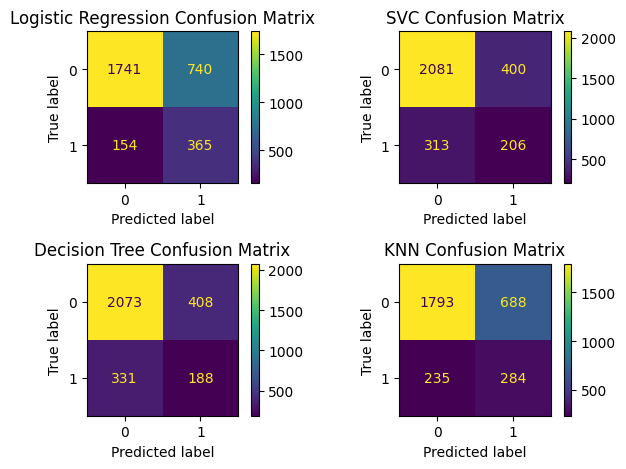

In [40]:
# Plot Logistic Regression Confusion Matrix"
fig, ax = plt.subplots(2, 2)

ConfusionMatrixDisplay(confusion_matrix(y_test, lgr_preds)).plot(ax =ax[0,0])
#plt.grid(False)
ax[0,0].set_title("Logistic Regression Confusion Matrix")

ConfusionMatrixDisplay(confusion_matrix(y_test, svc_preds)).plot(ax = ax[0,1])
#plt.grid(False)
ax[0,1].set_title("SVC Confusion Matrix")

ConfusionMatrixDisplay(confusion_matrix(y_test, tree_preds)).plot(ax = ax[1,0])
#plt.grid(False)
ax[1,0].set_title("Decision Tree Confusion Matrix")

ConfusionMatrixDisplay(confusion_matrix(y_test, knn_preds)).plot(ax = ax[1,1])
#plt.grid(False)
ax[1,1].set_title("KNN Confusion Matrix")

plt.tight_layout()

# Outcome
*   Based on the model tunning for accuracy, SVC outperforms all others models but, SVC takes a very long training time comparatavely.
* DecisionTreeClassifer is comparable with SVC for test accuracy of 75% , 20x faster then SVC but low Recall and Low F1 Score.
* KNN seems to be teh worst with lowest Test accuracy, Recall and F1 score
* **Logistic regression with C= 0.1 regularization seems to be the WINNER here with 70% Test accuracy and best Recall, F1 and AUC scores. Also Confusion matrix has least False Negative which is important for medical risk. Missing a disease i.e higher false negative can have severe consequences.**

# Feature importance
### Permutation Importance
* Positive Perumtation: Feature is important
* Negative Permutation: Feature is not important or weakly important

In [41]:
# Find the feature importance

#Calculate the permutation importance
from sklearn.inspection import permutation_importance

lgr_model = LogisticRegression(C= 0.1).fit(X_train_resampled, y_train_resampled)

lgr_score = lgr_model.score(X_test_scaled, y_test)
print(f"Logistic Regression Test Accuracy: {lgr_score}")

results = permutation_importance(lgr_model, X_test_scaled, y_test)


Logistic Regression Test Accuracy: 0.702


In [47]:
# Get feature names from the dataframe
feature_names = X.columns
importances = pd.DataFrame(data=results.importances_mean, index=feature_names, columns=['Importance']).sort_values(by='Importance', ascending=False)
importances.head(20)

,Importance
genhlth,7.933333e-03
bmi,4.600000e-03
diffwalk,2.266667e-03
exercise,1.733333e-03
menthlth,1.666667e-03
race,1.133333e-03
pa_level,6.666667e-04
Heart_disease,4.666667e-04
smoke100,4.000000e-04
insurance,-4.440892e-17


Text(0, 0.5, 'Importance')

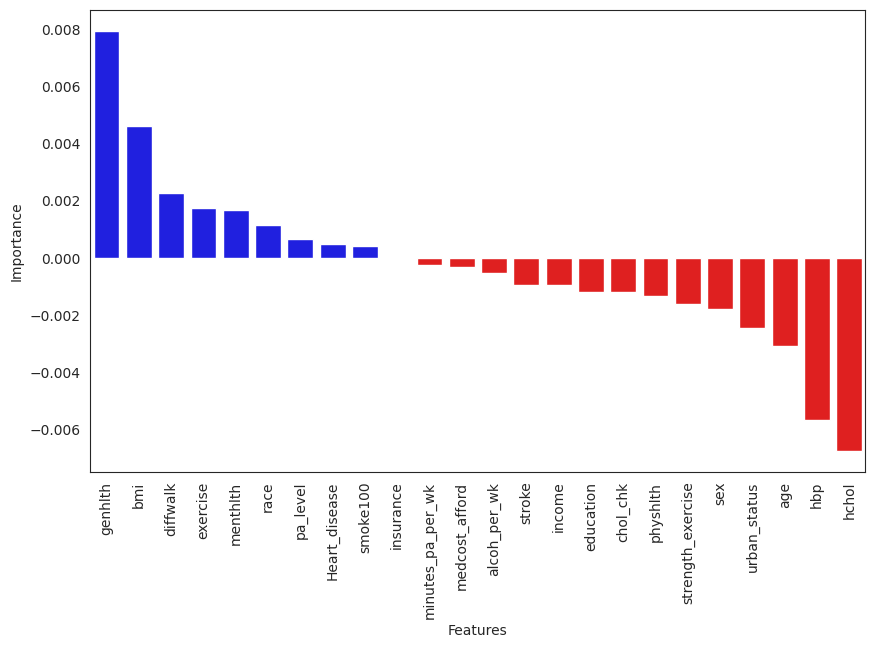

In [57]:
# Feature Importance bar Plot
plt.figure(figsize=(10, 6))
colors = ['red' if x < 0 else 'blue' for x in importances['Importance']]
sns.barplot(x=importances.index, y=importances['Importance'], palette=colors)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')

# Important features that significantly relates to diabetes risk are:
1. Genhlth -- General health of an individual
2. bmi -- Body mass index
3. diffwalk -- Having diffculty walking
4. exercise -- Physical activit or exercise
5. race -- Race
6. pa_activity -- What is the level of physical activity
7. Heart_desease -- Ever had coronary heart disease (CHD) or myocardial infarction (MI)
8. smoke100 -- Smoker